In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from IPython import display

In [2]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')

def load_review(path, is_pos=True):
    with open(path, encoding='latin-1') as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [5]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

In [6]:
from stop_words import get_stop_words

MAX_WORDS = 25
EMBEDDING_SIZE = 300

def process_review_dense(review, max_words=MAX_WORDS):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review_ = []
    for r in review:
        try:
            review_.append(word2vec_model[r])
        except KeyError:
            pass # word not found in the model
    review_ = review_[:max_words]
    return np.sum(np.asarray(review_), axis=0) 

In [7]:
def process_review_conv(review, max_words=MAX_WORDS):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review_ = []
    for r in review:
        try:
            review_.append(word2vec_model[r])
        except KeyError:
            review_.append(np.zeros(EMBEDDING_SIZE,)) # when word does not exist in vocab
    while len(review_) < max_words:
        review_.append(np.zeros(EMBEDDING_SIZE,))
    review_ = review_[:max_words]
    return review_

In [8]:
processed_review_conv = all_reviews.review.apply(lambda review: process_review_conv(review))
processed_review_dense = all_reviews.review.apply(lambda review: process_review_dense(review))

In [9]:
from sklearn.model_selection import train_test_split

X_dense = np.asarray(processed_review_dense).flatten()
X_dense_reshaped = np.zeros([len(X_dense), X_dense[0].shape[0]])
for i in range(len(X_dense)):
    X_dense_reshaped[i, :] = X_dense[i]
X_dense_reshaped_tf = tf.convert_to_tensor(X_dense_reshaped)

X_conv = processed_review_conv.to_numpy().tolist()
X_conv = tf.convert_to_tensor(X_conv)
X_conv_reshaped = tf.reshape(
    X_conv, [X_conv.shape[0], X_conv.shape[2], X_conv.shape[1], 1]) # one channel (black or white)

X_conv_reshaped_np = X_conv_reshaped.numpy()

y = all_reviews.sentiment.values
y_tf = tf.convert_to_tensor(y)

In [10]:
X_dense_reshaped.shape, X_conv_reshaped.shape, y.shape

((10695, 300), TensorShape([10695, 300, 25, 1]), (10695,))

In [11]:
X_conv_train, X_conv_test, X_dense_train, X_dense_test, y_train, y_test = train_test_split(X_conv_reshaped_np, X_dense_reshaped, y, random_state=42)

In [12]:
X_conv_train.shape, X_conv_test.shape, X_dense_train.shape, X_dense_test.shape, y_train.shape, y_test.shape

((8021, 300, 25, 1),
 (2674, 300, 25, 1),
 (8021, 300),
 (2674, 300),
 (8021,),
 (2674,))

In [33]:
class ConvDenseTextModel(tf.keras.Model):
    def __init__(self, embedding_size=EMBEDDING_SIZE, max_words=MAX_WORDS):
        super(ConvDenseTextModel, self).__init__()
        self.concat_size = 128
        
        # convolutional part of the model
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(embedding_size, max_words, 1))
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2))
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        
        # dense part of the model
        self.dense2 = tf.keras.layers.Dense(256, activation='relu', input_shape=(embedding_size,))
        self.dense3 = tf.keras.layers.Dense(128, activation='relu')
        self.dense4 = tf.keras.layers.Dense(64, activation='relu')
        
        self.concat_layer1 = tf.keras.layers.Dense(10, activation='relu')
        self.concat_layer2 = tf.keras.layers.Dense(10, activation='relu')
        self.dense5 = tf.keras.layers.Dense(1, activation='sigmoid')
        self.dropout = tf.keras.layers.Dropout(0.4)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs, training=False):
        X_conv, X_dense = inputs
        
        X_conv = self.conv1(X_conv)
        X_conv = self.pool1(X_conv)
        X_conv = self.conv2(X_conv)
        X_conv = self.pool2(X_conv)
        if training:    
            X_conv = self.batch_norm(X_conv)
        X_conv = tf.keras.layers.Flatten()(X_conv)
        if training:
            X_conv = self.dropout(X_conv)
        X_conv = self.dense1(X_conv)
        X_conv = self.concat_layer1(X_conv)
        
        X_dense = self.dense2(X_dense)
        if training:
            X_dense = self.dropout(X_dense)
        X_dense = self.dense3(X_dense)
        if training:
            X_dense = self.dropout(X_dense)
        X_dense = self.dense4(X_dense)
        X_dense = self.concat_layer2(X_dense)
        
        X = tf.concat([X_conv, X_dense], axis=1)
        return self.dense5(X)

In [34]:
model = ConvDenseTextModel()

In [35]:
METRICS = [
    tf.keras.metrics.Accuracy(name='accuracy'),
    tf.keras.metrics.Recall(name='recall'),
]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

In [36]:
EPOCHS = 5
BATCH_SIZE = 64

history = model.fit((X_conv_train, X_dense_train),
                    y_train,
                    validation_data=((X_conv_test, X_dense_test), y_test),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Train on 8021 samples, validate on 2674 samples
Epoch 1/5
8021/8021 [==============================] - 54s 7ms/sample - loss: 0.6267 - accuracy: 0.0000e+00 - recall: 0.6591 - val_loss: 0.5233 - val_accuracy: 0.0000e+00 - val_recall: 0.6334
Epoch 2/5
8021/8021 [==============================] - 69s 9ms/sample - loss: 0.5208 - accuracy: 0.0000e+00 - recall: 0.7502 - val_loss: 0.4848 - val_accuracy: 0.0000e+00 - val_recall: 0.7675
Epoch 3/5
8021/8021 [==============================] - 56s 7ms/sample - loss: 0.4914 - accuracy: 0.0000e+00 - recall: 0.7527 - val_loss: 0.4744 - val_accuracy: 0.0000e+00 - val_recall: 0.7809
Epoch 4/5
8021/8021 [==============================] - 52s 6ms/sample - loss: 0.4731 - accuracy: 0.0000e+00 - recall: 0.7635 - val_loss: 0.4770 - val_accuracy: 0.0000e+00 - val_recall: 0.6915
Epoch 5/5
8021/8021 [==============================] - 57s 7ms/sample - loss: 0.4592 - accuracy: 0.0000e+00 - recall: 0.7587 - val_loss: 0.4718 - val_accuracy: 0.0000e+00 - val_recall:

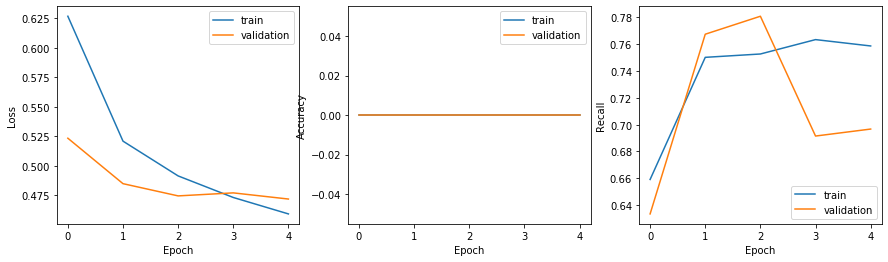

In [37]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [38]:
def predict(review, max_words=MAX_WORDS, shape=(EMBEDDING_SIZE,)):
    def process_input(review, fn, shape):
        input_ = [p for p in fn(review)]
        input_ = tf.cast(input_, tf.float32)
        input_ = tf.reshape(input_, shape)
        input_ = input_[np.newaxis, ...]
        return input_
    
    input_conv = process_input(review, process_review_conv, shape=(EMBEDDING_SIZE, MAX_WORDS, 1))
    input_dense = process_input(review, process_review_dense, shape=(EMBEDDING_SIZE,))
    prediction = model.predict((input_conv, input_dense))[0][0]
    print(prediction)
    if prediction > 0.5:
        print('Positive review with probability: {:.2f}%'.format(prediction * 100))
    else:
        print('Negative review with probability: {:.2f}%'.format(100 - prediction * 100))

In [39]:
predict("The movie was so bad")

0.107266374
Negative review with probability: 89.27%


### Rewrite in functional API for plotting model

In [40]:
def createConvDenseTextModel(embedding_size=EMBEDDING_SIZE, max_words=MAX_WORDS):
    concat_size = 128    
    # convolutional part of the model
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(embedding_size, max_words, 1))
    pool1 = tf.keras.layers.MaxPool2D((2, 2))
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
    pool2 = tf.keras.layers.MaxPool2D((2, 2))
    dense1 = tf.keras.layers.Dense(512, activation='relu')
        
    # dense part of the model
    dense2 = tf.keras.layers.Dense(256, activation='relu', input_shape=(embedding_size,))
    dense3 = tf.keras.layers.Dense(128, activation='relu')
    dense4 = tf.keras.layers.Dense(64, activation='relu')
        
    concat_layer1 = tf.keras.layers.Dense(10, activation='relu')
    concat_layer2 = tf.keras.layers.Dense(10, activation='relu')
    dense5 = tf.keras.layers.Dense(1, activation='sigmoid')
    dropout = tf.keras.layers.Dropout(0.4)
    batch_norm = tf.keras.layers.BatchNormalization()
    
    X_conv_in = tf.keras.Input(shape=(embedding_size, max_words, 1))
    X_dense_in = tf.keras.Input(shape=(embedding_size,))
        
    X_conv = conv1(X_conv_in)
    X_conv = pool1(X_conv)
    X_conv = conv2(X_conv)
    X_conv = pool2(X_conv)
    X_conv = batch_norm(X_conv)
    X_conv = tf.keras.layers.Flatten()(X_conv)
    # X_conv = dropout(X_conv)
    X_conv = dense1(X_conv)
    X_conv = concat_layer1(X_conv)
        
    X_dense = dense2(X_dense_in)
    # X_dense = dropout(X_dense)
    X_dense = dense3(X_dense)
    # X_dense = dropout(X_dense)
    X_dense = dense4(X_dense)
    X_dense = concat_layer2(X_dense)
    
    X = tf.concat([X_conv, X_dense], axis=1)
    X = dense5(X)
    
    model = tf.keras.Model(inputs=[X_conv_in, X_dense_in], outputs=X, name='cnn_and_dense_model')
    return model

In [41]:
model1 = createConvDenseTextModel()

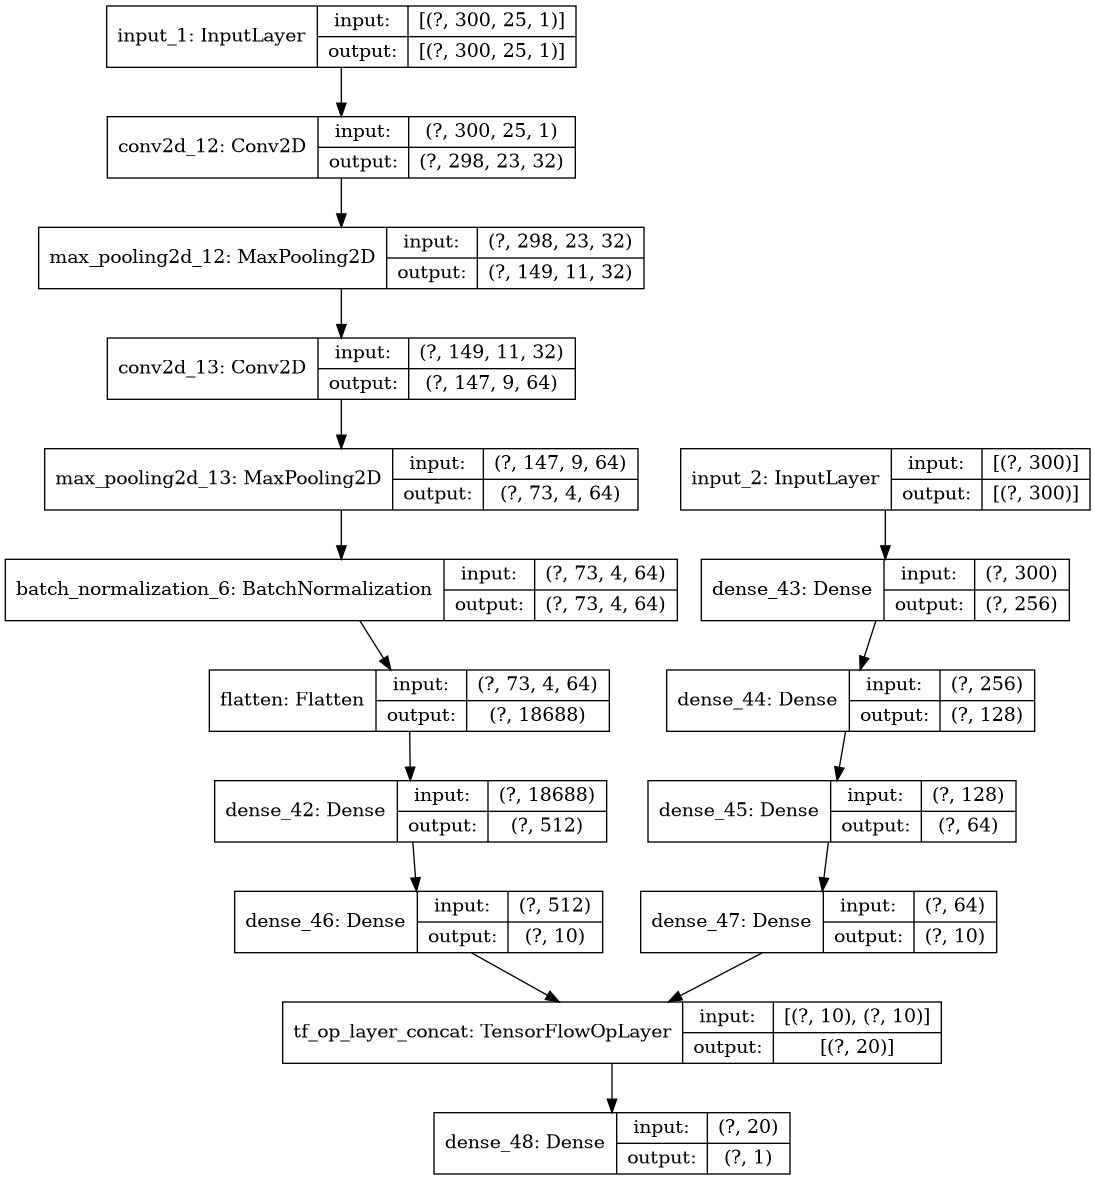

In [42]:
tf.keras.utils.plot_model(model1, 'cnn_and_dense_model.png', show_shapes=True)